## 作業二 - CIFAR10_Softmax_TF 

CIFAR10 是另外一個 dataset， 和 mnist 一樣，有十種類別（飛機、汽車、鳥、貓、鹿、狗、青蛙、馬、船、卡車）

https://www.cs.toronto.edu/~kriz/cifar.html


<a id='import'></a>
## Import Package & Functions

In [ ]:
import keras
from keras.models import Sequential
from PIL import Image
import numpy as np
import tarfile
import os
import urllib
from urllib.request import urlretrieve
from IPython.display import display
import sys
import tensorflow as tf

In [ ]:
def showX(X):
    int_X = (X*255).clip(0,255).astype('uint8')
    # N*3072 -> N*3*32*32 -> 32 * 32N * 3
    int_X_reshape = np.moveaxis(int_X.reshape(-1,3,32,32), 1, 3)
    int_X_reshape = int_X_reshape.swapaxes(0,1).reshape(32,-1, 3)
    display(Image.fromarray(int_X_reshape))

In [42]:
def updateProgress(msg):
    sys.stdout.write('\r')
    sys.stdout.write(msg)
    sys.stdout.flush()

## 1. 下載 dataset

In [4]:
url = "https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"
def reporthook(a,b,c):
    print("\rdownloading: %5.1f%%"%(a*b*100.0/c), end="")
tar_gz = "cifar-10-python.tar.gz"
if not os.path.isfile(tar_gz):
        print('Downloading data from %s' % url)
        urlretrieve(url, tar_gz, reporthook=reporthook)

In [5]:
# 讀取 dataset
# 只有 train 和 test 沒有 validation
import pickle
train_X=[]
train_y=[]
tar_gz = "cifar-10-python.tar.gz"
with tarfile.open(tar_gz) as tarf:
    for i in range(1, 6):
        dataset = "cifar-10-batches-py/data_batch_%d"%i
        print("load",dataset)
        with tarf.extractfile(dataset) as f:
            result = pickle.load(f, encoding='latin1')
        train_X.extend(result['data']/255)
        train_y.extend(result['labels'])
    train_X=np.float32(train_X)
    train_y=np.int32(train_y)
    dataset = "cifar-10-batches-py/test_batch"
    print("load",dataset)
    with tarf.extractfile(dataset) as f:
        result = pickle.load(f, encoding='latin1')
        test_X=np.float32(result['data']/255)
        test_y=np.int32(result['labels'])
train_Y = np.eye(10)[train_y]
test_Y = np.eye(10)[test_y]

load cifar-10-batches-py/data_batch_1
load cifar-10-batches-py/data_batch_2
load cifar-10-batches-py/data_batch_3
load cifar-10-batches-py/data_batch_4
load cifar-10-batches-py/data_batch_5
load cifar-10-batches-py/test_batch


### 查看一下資料

In [9]:
train_X.shape

(50000, 3072)

In [16]:
# channels x 高 x 寬 (顏色)
3*32*32

3072

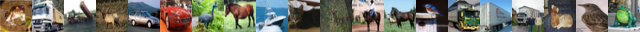

[6 9 9 4 1 1 2 7 8 3 4 7 7 2 9 9 9 3 2 6]
['青蛙' '卡車' '卡車' '鹿' '汽車' '汽車' '鳥' '馬' '船' '貓' '鹿' '馬' '馬' '鳥' '卡車' '卡車'
 '卡車' '貓' '鳥' '青蛙']


In [17]:
# 訓練資料， X 的前 20 筆
showX(train_X[:20])
print(train_y[:20])
name_array = np.array("飛機、汽車、鳥、貓、鹿、狗、青蛙、馬、船、卡車".split('、'))
print(name_array[train_y[:20]])

<a id='開始Machine Learning'></a>
## 2. 開始Machine Learning - Softmax regression 
- Machine Learning ABC 
    -  [A. 定義參數](#定義參數) 
    -  [B. 設計一個Model從X預測Y](#設計一個) 
    -  [C. 選一個loss function,](#選一個loss) 
    -  [D. 選一個optimizer](#選一個o) 
    -  [E. 開始執行訓練](#開始執行) 
    -  [F. 算一下正確率](#算一下正)  

## Q 
* 將之前的 logistic regression 套用過來看看
* 試試看改善準確度
* activation 換成其他的？
* optimizer 換成其他的？
* loss function 換成其他的？

In [26]:
tf.reset_default_graph()
# 輸入的 placeholder
X = tf.placeholder(tf.float32, shape=[None, 3072], name="X")
# 權重參數，為了計算方便和一些慣例（行向量及列向量的差異），矩陣乘法的方向和上面解說相反
W = tf.Variable(tf.zeros([3072, 10]), name='W')
b = tf.Variable(tf.zeros([10]), name='b') # 這裡可以看成是列向量

# 真正的 Y
Y_ = tf.placeholder(tf.float32, shape=[None, 10], name="Y_")


In [29]:
Y= tf.add(x= tf.matmul(X, W, name='e'), y=b, name='Y')
Y_softmax = tf.nn.softmax(Y, name='Y_softmax') #這個是one-hot的格式

Y_softmax_argmax = tf.argmax(Y_softmax, axis=1) #從one-hot的格式找出最大那個
#Y_softmax = tf.div(Y, tf.reduce_sum(Y, axis=1, keep_dims=True), name="Y_softmax")
correct_prediction = tf.equal(Y_softmax_argmax, tf.argmax(Y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))


In [30]:
#loss_fun = tf.reduce_mean(tf.squared_difference(Y_softmax, Y_))
#loss_fun = tf.reduce_mean(-tf.reduce_sum(Y_*tf.log(Y_softmax), axis=1))
# or
loss_fun = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=Y_, logits=Y))


In [34]:
learning_rate = 0.01
optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss_fun)
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss_fun)

In [35]:
#先創造一個session, 然後記得要init variable
sess = tf.InteractiveSession()
tf.global_variables_initializer().run()

In [43]:
epoch = 10
for ep in range(epoch):
    for i in range(1000):
        rnd_idx = np.random.choice(train_X.shape[0], 50, replace=False)
        optimizer.run(feed_dict={X: train_X[rnd_idx], Y_:train_Y[rnd_idx]})
        if i%100 ==0:
            a = accuracy.eval({X: test_X , Y_: test_Y})
            l=loss_fun.eval({X: test_X , Y_: test_Y})
            updateProgress('ep:{x0}, loss:{x3}, acc:{x2}'.format(x0=ep,x1=i,x2=a,x3=l))
    print()


ep:0, loss:1.8515654802322388, acc:0.34970000386238124
ep:1, loss:1.7926414012908936, acc:0.38159999251365666
ep:2, loss:1.826781988143921, acc:0.337399989366531375


In [46]:
# predict all X and get the accuracy
_ = accuracy.eval({X: test_X , Y_: test_Y})
print('Accuracy:',_)

Accuracy: 0.3634
